### Resource-bounded Fraud Detection (Luis Torgo)

https://www.dcc.fc.up.pt/~ltorgo/Papers/Tor07.pdf

**Abstract.** This paper describes an approach to fraud detection targeted at applications where this task is followed by a posterior human analysis of the signaled frauds. This is a frequent setup on fraud detection applications (e.g. credit card misuse, telecom fraud, etc.). In real world applications this human inspection is usually constrained by limited resources. In this context, standard fraud detection methods that simply tag each case as being (or not) a possible fraud are not very useful if the number of tagged cases surpasses the available resources. A much more useful approach is to produce a ranking of fraud that can be used to optimize the available inspection resources by first addressing the cases with higher rank. In this paper we propose a method that produces such ranking. The method is based on the output of standard agglomerative hierarchical clustering algorithms, resulting in no significant additional computational costs. Our comparisons with a state of the art method provide convincing evidence of the competitiveness of our proposal.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

In [175]:
np.set_printoptions(suppress=True)

In [2]:
df = pd.read_csv('boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
X = df.drop(columns='medv')

In [4]:
d = pdist(X, metric='euclidean')

In [5]:
# A by 4 matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] 
# are combined to form cluster n+i. A cluster with an index less than n corresponds to one of the 
# n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. 
# The fourth value Z[i, 3] represents the number of original observations in the newly formed 
# cluster.

Z = linkage(d, method='ward')
Z.shape

(505, 4)

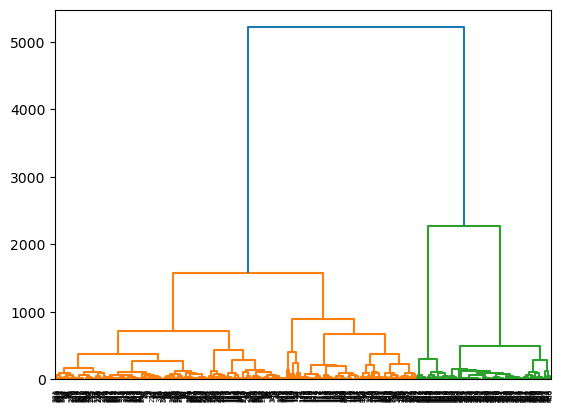

In [6]:
fig, ax = plt.subplots()
dendrogram(Z, ax=ax);

In [7]:
def get_instances(i, c):
    if i < N:
        return [i]
    else:
        return c[i]
    
def OF(g, i, N):
    return (1 - len(g)/N) * i/N    

In [8]:
outlier_factor = defaultdict(list)
clusters = defaultdict(list)
N = X.shape[0]
nrows = Z.shape[0]
cluster_idx = N

for i in range(nrows):
    i1, i2, cluster_size = Z[i, [0, 1, 3]].astype(np.int64)
    g1 = get_instances(i1, clusters)
    g2 = get_instances(i2, clusters)
    clusters[cluster_idx].extend(g1)
    clusters[cluster_idx].extend(g2)
    
    assert cluster_size == len(clusters[cluster_idx])
    
    gs, gl = (g1, g2) if len(g1) < len(g2) else (g2, g1)
    
    score = OF(gs, i, N)
    for idx in gs:
        outlier_factor[idx].append(score)
    for idx in gl:
        outlier_factor[idx].append(0)

    cluster_idx += 1

In [9]:
# OF(x) = max OF(g) where g ∈ Gx (Gx is the set of groups in the dendogram to which x belongs)
scores = {}
for k, v in outlier_factor.items():
    scores[k] = np.max(v)
    
df_scores = pd.DataFrame({'Score': scores.values()}, index=scores.keys())

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [11]:
prop_var = np.sum(pca.explained_variance_ratio_) * 100

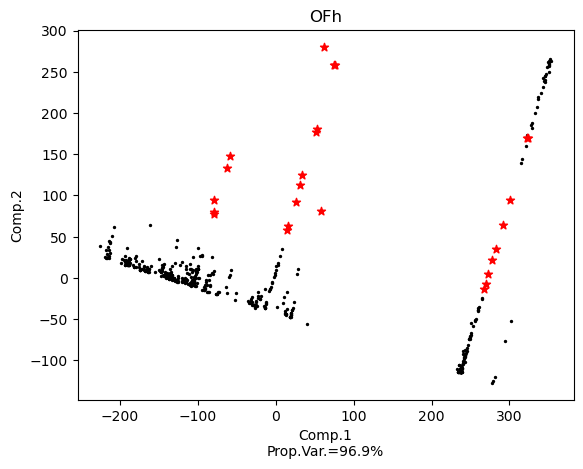

In [13]:
outliers = df_scores.sort_values(by='Score', ascending=False).head(25).index.to_list()

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2, c='black')
plt.scatter(X_pca[outliers, 0], X_pca[outliers, 1],  c='red', marker='*')
plt.xlabel(f'Comp.1\nProp.Var.={prop_var:.1f}%')
plt.ylabel('Comp.2')
plt.title('OFh');